# IMPORTS

In [1]:
print('.')
import numpy as np
import pandas as pd

import os, sys, random, time

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

print('...done importing')

.
...done importing


# Load Data

In [2]:
# SMALL_TEST = True
SMALL_TEST = False
N_SPLITS = 5
SEED = 1042

train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
orig = pd.read_csv('/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv')

TARGET = 'loan_paid_back'

if SMALL_TEST:
    train = train[:20000]

print(train.shape, test.shape, orig.shape)
train

(593994, 13) (254569, 12) (20000, 22)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
593989,593989,23004.26,0.152,703,20958.37,10.92,Female,Single,High School,Employed,Business,C3,1.0
593990,593990,35289.43,0.105,559,3257.24,14.62,Male,Single,Bachelor's,Employed,Debt consolidation,F5,1.0
593991,593991,47112.64,0.072,675,929.27,14.13,Female,Married,Bachelor's,Employed,Debt consolidation,C1,1.0
593992,593992,76748.44,0.067,740,16290.40,9.87,Male,Single,Bachelor's,Employed,Debt consolidation,B2,1.0


In [3]:
df = train
df.info()
df.describe()
df.isnull().sum()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB
                  id  annual_income  debt_to_i

# 1. Exploratory Data Analysis

Decide what and how much data analysis you want to do.

Can copy code from other notebooks, but other options:
 - copy the list of features (column names) into ChatGPT, and give a long prompt asking ChatGPT for some EDA ideas of useful graphs
 - Review a bunch of notebooks, and just pick a few favorite ideas, or merge and combine a few ideas from other notebooks into your own slightly changed version.
 - Review notebooks from some OTHER competition (last month's competition), and modify those ideas to work on the data of this competition.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


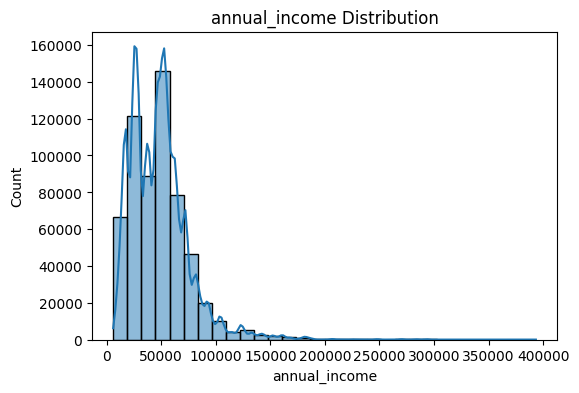

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


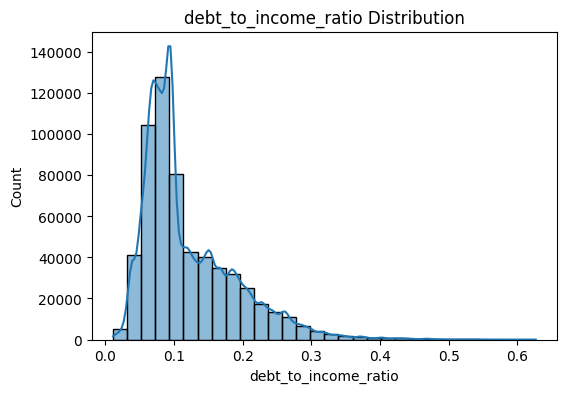

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


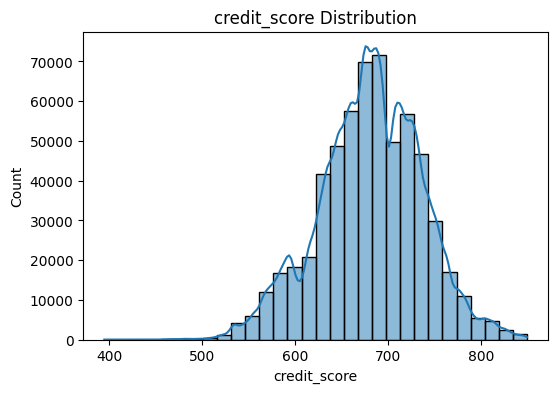

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


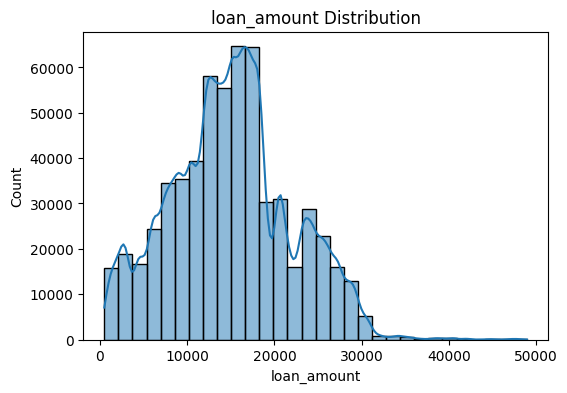

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


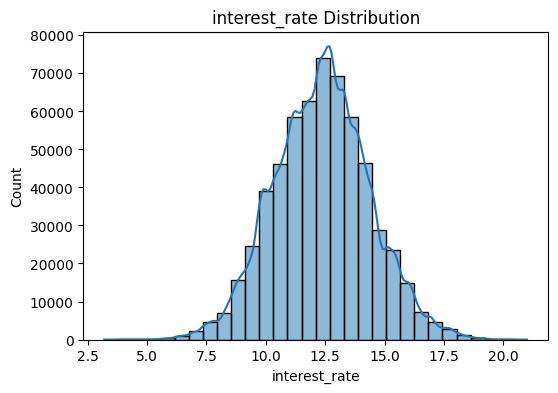

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'{col} Distribution')
    plt.show()

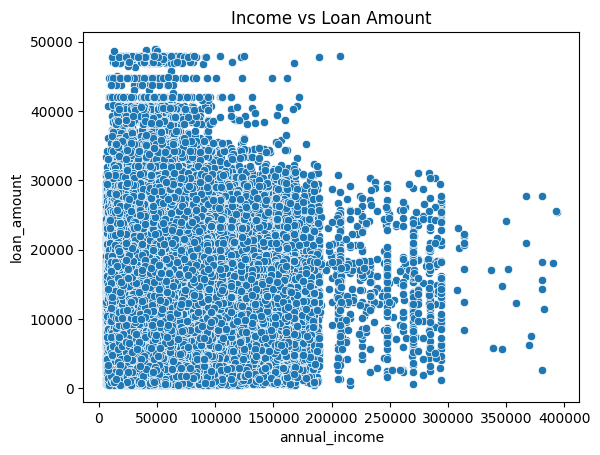

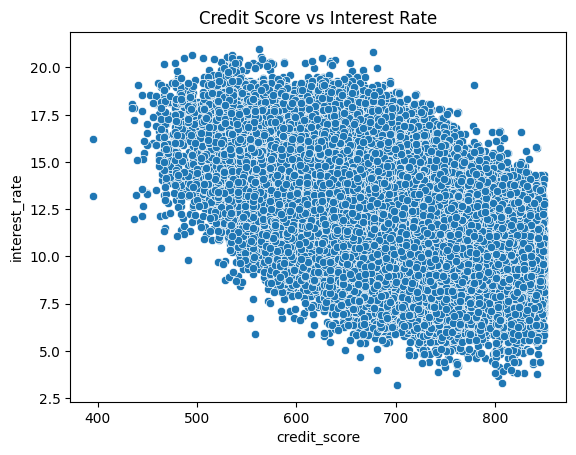

In [5]:
sns.scatterplot(x='annual_income', y='loan_amount', data=df)
plt.title('Income vs Loan Amount')
plt.show()

sns.scatterplot(x='credit_score', y='interest_rate', data=df)
plt.title('Credit Score vs Interest Rate')
plt.show()

In [6]:
import numpy as np
import pandas as pd

pd.set_option("display.precision", 2)
train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.08,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.17,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.10,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.07,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.05,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [7]:
print(train.shape)
print(train.columns)

(593994, 13)
Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back'],
      dtype='object')


In [8]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB
None


In [9]:
train.describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.00,593994.00,593994.00,593994.00,593994.00,593994.00,593994.0
mean,296996.50,48212.20,0.12,680.92,15020.30,12.36,0.8
std,171471.44,26711.94,0.07,55.42,6926.53,2.01,0.4
min,0.00,6002.43,0.01,395.00,500.09,3.20,0.0
25%,148498.25,27934.40,0.07,646.00,10279.62,10.99,1.0
50%,296996.50,46557.68,0.10,682.00,15000.22,12.37,1.0
75%,445494.75,60981.32,0.16,719.00,18858.58,13.68,1.0
max,593993.00,393381.74,0.63,849.00,48959.95,20.99,1.0


In [10]:
train.describe(include=["object", "bool"])

,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
count,593994,593994,593994,593994,593994,593994
unique,3,4,5,5,8,30
top,Female,Single,Bachelor's,Employed,Debt consolidation,C3
freq,306175,288843,279606,450645,324695,58695


In [11]:
CATS = [
    "gender",
    "marital_status",
    "education_level",
    "employment_status",
    "loan_purpose",
    "grade_subgrade"
]

for col in CATS:
    print("Column:", col)
    print(train[col].value_counts())
    print(train[col].value_counts(normalize=True))
    print()

Column: gender
gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64
gender
Female    5.15e-01
Male      4.78e-01
Other     6.28e-03
Name: proportion, dtype: float64

Column: marital_status
marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64
marital_status
Single      0.49
Married     0.47
Divorced    0.04
Widowed     0.01
Name: proportion, dtype: float64

Column: education_level
education_level
Bachelor's     279606
High School    183592
Master's        93097
Other           26677
PhD             11022
Name: count, dtype: int64
education_level
Bachelor's     0.47
High School    0.31
Master's       0.16
Other          0.04
PhD            0.02
Name: proportion, dtype: float64

Column: employment_status
employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64
employment_status
Employed    

In [12]:
print(train['loan_paid_back'].mean())

0.7988195166954548


In [13]:
 # What is the average credit score among borrowers who did not pay back their loan?
df[df["loan_paid_back"] == 0]["credit_score"].mean()

655.0106276150627

In [14]:
# 2) Among borrowers who did pay back their loan and have a debt-to-income ratio below 20%, what is the median loan amount?
df[(df["loan_paid_back"] == 1) & (df["debt_to_income_ratio"] < 0.20)]["loan_amount"].median()

14970.91

In [15]:
# 3) What is the maximum interest rate for borrowers with an annual income above $100k who defaulted (loan_paid_back == 0)?
df[(df["annual_income"] > 100000) & (df["loan_paid_back"] == 0)]["interest_rate"].max()

20.49

In [16]:
# 4) Among borrowers who paid back their loan, which education level has the highest average credit score?
df[df["loan_paid_back"] == 1].groupby("education_level")["credit_score"].mean().sort_values(ascending=False).head(1)

education_level
Other    688.1
Name: credit_score, dtype: float64

In [17]:
# 5) For loans used for debt consolidation, what is the average loan amount for borrowers who did not pay back their loan?
df[(df["loan_purpose"] == "debt_consolidation") & (df["loan_paid_back"] == 0)]["loan_amount"].mean()

nan

In [18]:
# 6Are males or females more likely to default?
train.groupby("gender")["loan_paid_back"].mean()

gender
Female    0.8
Male      0.8
Other     0.8
Name: loan_paid_back, dtype: float64

In [19]:
#7 Which employment status group has the highest default rate?
df.groupby("employment_status")["loan_paid_back"].mean().sort_values()

employment_status
Unemployed       0.08
Student          0.26
Employed         0.89
Self-employed    0.90
Retired          1.00
Name: loan_paid_back, dtype: float64

In [20]:
#8 Which employment status group has the highest default rate?
df.groupby("marital_status")["loan_amount"].median()

marital_status
Divorced    14920.66
Married     14972.33
Single      15011.15
Widowed     15166.94
Name: loan_amount, dtype: float64

In [21]:
columns_to_show = ["credit_score", "annual_income", "loan_amount"]

train.groupby("loan_paid_back")[columns_to_show].describe(percentiles=[])

credit_score                                     annual_income  \
                      count    mean    std    min    50%    max         count   
loan_paid_back                                                                  
0.0                119500.0  655.01  51.68  395.0  657.0  849.0      119500.0   
1.0                474494.0  687.44  54.42  395.0  688.0  849.0      474494.0   

                                                                loan_amount  \
                   mean       std      min       50%        max       count   
loan_paid_back                                                                
0.0             47875.5  27199.06  6098.80  45935.39  393381.74    119500.0   
1.0             48297.0  26587.21  6002.43  46664.37  393064.03    474494.0   

                                                               
                    mean      std     min       50%       max  
loan_paid_back                                                 
0.0             15072.22  6945.37  507.42  15078.79  48959.95  
1.0             15007.22  6921.72  500.09  14957.85  48954.70

In [22]:
pd.crosstab(
    df["loan_paid_back"],
    df["loan_purpose"],
    normalize=True
)

loan_purpose,Business,Car,Debt consolidation,Education,Home,Medical,Other,Vacation
loan_paid_back,,,,,,,,
0.0,0.01,0.02,0.11,0.01,0.01,8.52e-03,0.02,2.90e-03
1.0,0.05,0.08,0.44,0.05,0.06,2.99e-02,0.09,1.13e-02


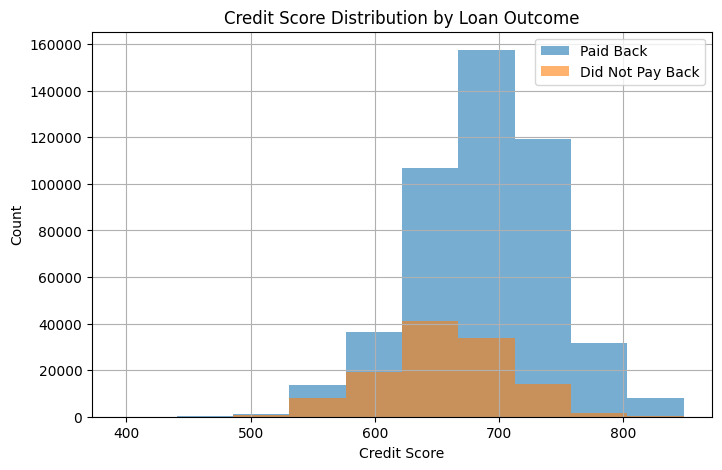

In [23]:
import matplotlib.pyplot as plt 
plt.figure(figsize=( 8 , 5 )) 
df[df[ "loan_paid_back" ] == 1 ][ "credit_score" ].hist(alpha= 0.6 , label= "Paid Back" ) 
df[df[ "loan_paid_back" ] == 0 ][ "credit_score" ].hist(alpha= 0.6 , label= "Did Not Pay Back" ) 
plt.xlabel( "Credit Score" ) 
plt.ylabel( "Count" ) 
plt.title( "Credit Score Distribution by Loan Outcome" ) 
plt.legend() 
plt.show()

<Figure size 800x500 with 0 Axes>

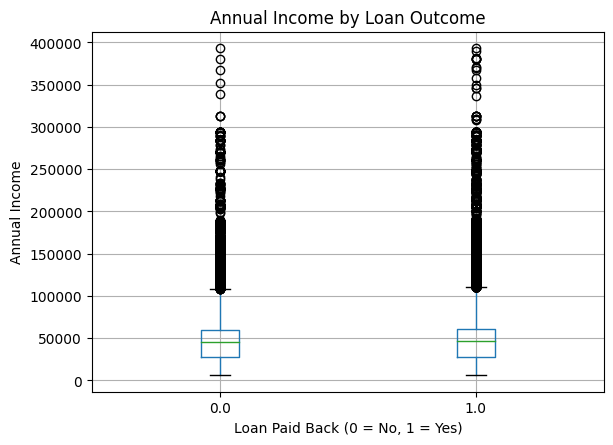

In [24]:
plt.figure(figsize=( 8 , 5 )) 
df.boxplot(column= "annual_income" , by= "loan_paid_back" ) 
plt.title( "Annual Income by Loan Outcome" ) 
plt.suptitle( "" ) # removes default pandas title 
plt.xlabel( "Loan Paid Back (0 = No, 1 = Yes)" ) 
plt.ylabel( "Annual Income" ) 
plt.show()


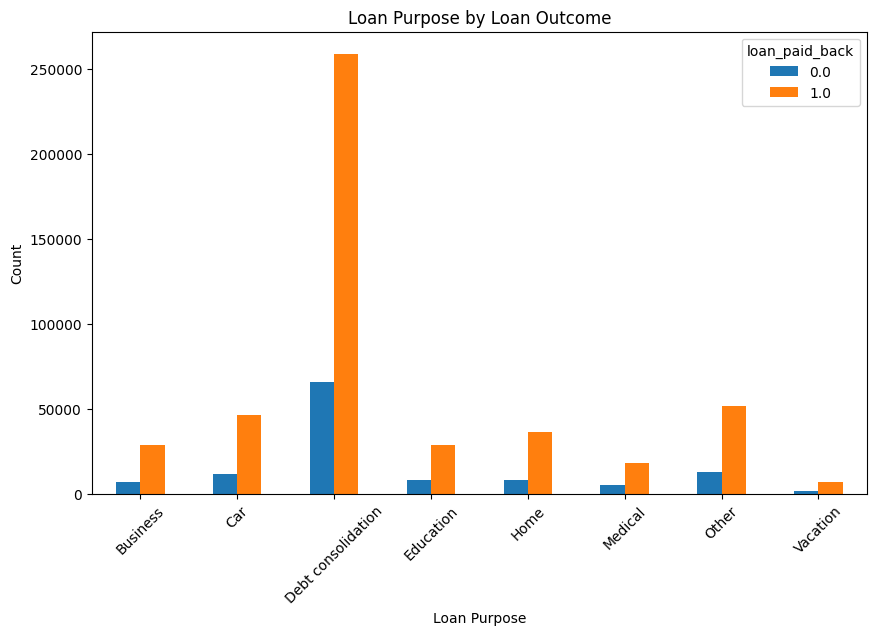

In [25]:
purpose_counts = df.groupby([ "loan_purpose" , "loan_paid_back" ]).size().unstack() 
purpose_counts.plot(kind= "bar" , figsize=( 10 , 6 )) 
plt.xlabel( "Loan Purpose" ) 
plt.ylabel( "Count" ) 
plt.title( "Loan Purpose by Loan Outcome" ) 
plt.xticks(rotation= 45 ) 
plt.show()

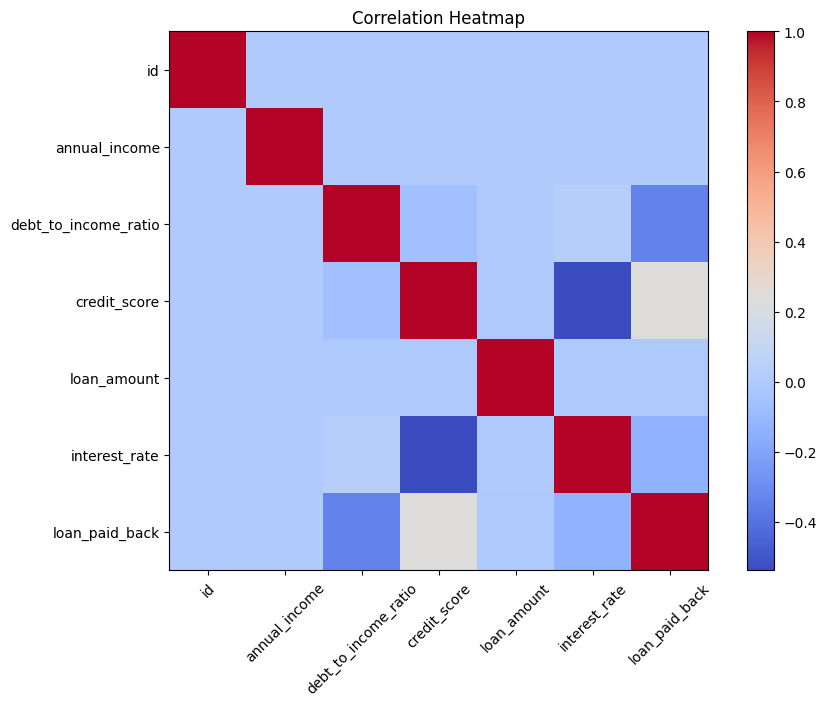

In [26]:
 import numpy as np 
numeric_df = df.select_dtypes(include=[ "float64" , "int64" ]) 
corr = numeric_df.corr() 
plt.figure(figsize=( 10 , 7 )) 
plt.imshow(corr, cmap= "coolwarm" , interpolation= "nearest" ) 
plt.colorbar() 
plt.xticks( range ( len (corr.columns)), corr.columns, rotation= 45 ) 
plt.yticks( range ( len (corr.columns)), corr.columns) 
plt.title( "Correlation Heatmap" ) 
plt.show()

# FEATURE ENGINEERING

From this [notebook](https://www.kaggle.com/code/analyticaobscura/s5e11-loan-payback-xgb-lgbm-ann)
- Creating original dataset target encoding features
- Engineering financial ratios and risk scores
- Building interaction terms for enhanced predictions

In [27]:
BASE = [col for col in train.columns if col not in ['id', TARGET, 'grade']]

In [28]:
for col in BASE:
    mean_map = orig.groupby(col)[TARGET].mean()
    train[f"orig_mean_{col}"] = train[col].map(mean_map)
    test[f"orig_mean_{col}"] = test[col].map(mean_map)
    
    count_map = orig.groupby(col).size()
    train[f"orig_count_{col}"] = train[col].map(count_map)
    test[f"orig_count_{col}"] = test[col].map(count_map)

train['loan_to_income'] = train['loan_amount'] / (train['annual_income'] + 1)
test['loan_to_income'] = test['loan_amount'] / (test['annual_income'] + 1)

train['total_debt'] = train['debt_to_income_ratio'] * train['annual_income']
test['total_debt'] = test['debt_to_income_ratio'] * test['annual_income']

train['available_income'] = train['annual_income'] * (1 - train['debt_to_income_ratio'])
test['available_income'] = test['annual_income'] * (1 - test['debt_to_income_ratio'])

train['affordability'] = train['available_income'] / (train['loan_amount'] + 1)
test['affordability'] = test['available_income'] / (test['loan_amount'] + 1)

train['monthly_payment'] = train['loan_amount'] * (1 + train['interest_rate']/100) / 12
test['monthly_payment'] = test['loan_amount'] * (1 + test['interest_rate']/100) / 12

train['payment_to_income'] = train['monthly_payment'] / (train['annual_income']/12 + 1)
test['payment_to_income'] = test['monthly_payment'] / (test['annual_income']/12 + 1)

train['risk_score'] = (train['debt_to_income_ratio'] * 40 + 
                       (1 - train['credit_score']/850) * 30 + train['interest_rate'] * 2)
test['risk_score'] = (test['debt_to_income_ratio'] * 40 + 
                      (1 - test['credit_score']/850) * 30 + test['interest_rate'] * 2)

train['grade'] = train['grade_subgrade'].str[0]
test['grade'] = test['grade_subgrade'].str[0]

train['grade_number'] = train['grade_subgrade'].str[1].astype(int)
test['grade_number'] = test['grade_subgrade'].str[1].astype(int)

grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
train['grade_rank'] = train['grade'].map(grade_map)
test['grade_rank'] = test['grade'].map(grade_map)

train['grade_combined'] = train['grade_rank'] * 10 + train['grade_number']
test['grade_combined'] = test['grade_rank'] * 10 + test['grade_number']

train['credit_interest'] = train['credit_score'] * train['interest_rate'] / 100
test['credit_interest'] = test['credit_score'] * test['interest_rate'] / 100

train['income_credit'] = np.log1p(train['annual_income']) * train['credit_score'] / 1000
test['income_credit'] = np.log1p(test['annual_income']) * test['credit_score'] / 1000

train['debt_loan'] = train['debt_to_income_ratio'] * np.log1p(train['loan_amount'])
test['debt_loan'] = test['debt_to_income_ratio'] * np.log1p(test['loan_amount'])

train['log_income'] = np.log1p(train['annual_income'])
test['log_income'] = np.log1p(test['annual_income'])

train['log_loan'] = np.log1p(train['loan_amount'])
test['log_loan'] = np.log1p(test['loan_amount'])

cat_cols = ['gender', 'marital_status', 'education_level', 
            'employment_status', 'loan_purpose', 'grade_subgrade']

for cat in cat_cols:
    mean_map = train.groupby(cat)['loan_amount'].mean()
    train[f'{cat}_loan_mean'] = train[cat].map(mean_map)
    test[f'{cat}_loan_mean'] = test[cat].map(mean_map)
    
    mean_map = train.groupby(cat)['credit_score'].mean()
    train[f'{cat}_credit_mean'] = train[cat].map(mean_map)
    test[f'{cat}_credit_mean'] = test[cat].map(mean_map)

num_cols = [col for col in train.columns if train[col].dtype in ['float64', 'int64'] 
            and col not in ['id', TARGET]]

for col in num_cols:
    if train[col].isnull().sum() > 0:
        median_val = train[col].median()
        train[col].fillna(median_val, inplace=True)
        test[col].fillna(median_val, inplace=True)

CATS = ['gender', 'marital_status', 'education_level', 
        'employment_status', 'loan_purpose', 'grade_subgrade', 'grade']
# CATS = ['gender', 'marital_status', 'education_level', 
#         'employment_status', 'loan_purpose', 'grade_subgrade', ]
FEATURES = [col for col in train.columns if col not in ['id', TARGET]]

train[CATS] = train[CATS].astype("category")
test[CATS] = test[CATS].astype("category")

print(len(CATS), len(FEATURES), FEATURES)

/tmp/ipykernel_13/2832931439.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(median_val, inplace=True)
/tmp/ipykernel_13/2832931439.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

7 61 ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'orig_mean_annual_income', 'orig_count_annual_income', 'orig_mean_debt_to_income_ratio', 'orig_count_debt_to_income_ratio', 'orig_mean_credit_score', 'orig_count_credit_score', 'orig_mean_loan_amount', 'orig_count_loan_amount', 'orig_mean_interest_rate', 'orig_count_interest_rate', 'orig_mean_gender', 'orig_count_gender', 'orig_mean_marital_status', 'orig_count_marital_status', 'orig_mean_education_level', 'orig_count_education_level', 'orig_mean_employment_status', 'orig_count_employment_status', 'orig_mean_loan_purpose', 'orig_count_loan_purpose', 'orig_mean_grade_subgrade', 'orig_count_grade_subgrade', 'loan_to_income', 'total_debt', 'available_income', 'affordability', 'monthly_payment', 'payment_to_income', 'risk_score', 'grade', 'grade_number', 'grade_rank', 'grade_combined', 'credit_in

# MODEL 1

How are we going to do hyperparameter tuning? Let's figure out and document a plan together

In [29]:
EARLY_STOPPING = 100

lgb_params = dict(
    ## Tuning parameters
    num_leaves=16, 
    colsample_bytree=0.2, 
    subsample=0.8, 
    reg_lambda=0.0, 

    ## Other parameters
    n_estimators=10000,
    learning_rate=0.01,
    random_state=42,
    n_jobs=-1,
    metric='auc',
    objective='binary',
    boosting_type='gbdt',
    bagging_freq=1,
)

In [30]:
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

train_oof_preds = np.zeros(train.shape[0])
test_preds = np.zeros(test.shape[0])
for f, (train_index, valid_index) in enumerate(kf.split(train)):
    train_xy = train.iloc[train_index]
    valid = train.iloc[valid_index]
    X_train = train_xy[FEATURES]
    y_train = train_xy[TARGET]
    X_valid = valid[FEATURES]
    y_valid = valid[TARGET]

    print(f'Fold {f}: X_train {X_train.shape}, y_train {y_train.shape}, X_valid {X_valid.shape}, y_valid {y_valid.shape},')
    model = LGBMClassifier(**lgb_params)

    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
              callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOPPING, verbose=True),
                         lgb.log_evaluation(period=EARLY_STOPPING)])
    p = model.predict_proba(X_valid)[:, 1]
    test_preds += model.predict_proba(test[FEATURES])[:, 1]
    train_oof_preds[valid_index] = p
    print(roc_auc_score(y_valid, p))
    print()

test_preds = test_preds / N_SPLITS
print("==========")
print(f"num_leaves: {lgb_params['num_leaves']}")
print(f"colsample_bytree: {lgb_params['colsample_bytree']}")
print(f"subsample: {lgb_params['subsample']}")
print(f"reg_lambda: {lgb_params['reg_lambda']}")
print("AUC score:", roc_auc_score(train[TARGET], train_oof_preds))

Fold 0: X_train (475195, 61), y_train (475195,), X_valid (118799, 61), y_valid (118799,),
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 379561, number of negative: 95634
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5572
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798748 -> initscore=1.378487
[LightGBM] [Info] Start training from score 1.378487
Training until validation sc

In [31]:
# num_leaves: 32
# colsample_bytree: 0.8
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.9244952538474238

# num_leaves: 32
# colsample_bytree: 0.8
# subsample: 0.8
# reg_lambda: 0.5
# AUC score: 0.9245234306501849

# num_leaves: 32
# colsample_bytree: 0.75
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.924507201955175

# num_leaves: 64
# colsample_bytree: 0.8
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.9243798381091557

# num_leaves: 32
# colsample_bytree: 0.8
# subsample: 0.75
# reg_lambda: 0.0
# AUC score: 0.924493165015794

# num_leaves: 16
# colsample_bytree: 0.8
# subsample: 0.8
# reg_lambda: 0.5
# AUC score: 0.924552444636332

# num_leaves: 16
# colsample_bytree: 0.75
# subsample: 0.8
# reg_lambda: 0
# AUC score: 0.9245733223004545

# num_leaves: 16
# colsample_bytree: 0.75
# subsample: 0.8
# reg_lambda: 0.5
# AUC score: 0.9245602767188259

# num_leaves: 24
# colsample_bytree: 0.75
# subsample: 0.8
# reg_lambda: 0.5
# AUC score: 0.9245570765690183

# num_leaves: 24
# colsample_bytree: 0.75
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.9245460870159629

# num_leaves: 16
# colsample_bytree: 0.75
# subsample: 0.85
# reg_lambda: 0.0
# AUC score: 0.9245682448634602

# num_leaves: 16
# colsample_bytree: 0.7
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.924576131070997

# num_leaves: 16
# colsample_bytree: 0.6
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.9246494863244146

# num_leaves: 16
# colsample_bytree: 0.5
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.9246673483118322

# num_leaves: 16
# colsample_bytree: 0.4
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.9247175272710239

# num_leaves: 16
# colsample_bytree: 0.3
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.924835459250641

# num_leaves: 16
# colsample_bytree: 0.2
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.9249114014836117

# num_leaves: 16
# colsample_bytree: 0.15
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.8825210467409519

# num_leaves: 16
# colsample_bytree: 0.25
# subsample: 0.8
# reg_lambda: 0.0
# AUC score: 0.9248862997205056

In [32]:
submission = pd.DataFrame({
    'id': test['id'],
    'target': test_preds
})

submission.to_csv('submission.csv', index=False)
submission

,id,target
0,593994,0.94
1,593995,0.97
2,593996,0.44
3,593997,0.92
4,593998,0.96
...,...,...
254564,848558,0.99
254565,848559,0.85
254566,848560,0.96
254567,848561,0.99


# DONE